In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_addons as tfa
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import random
import time
from pathlib import Path

import re
from IPython import display

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.2.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not support

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Preprocess Text

In [3]:
dictionary_path = './dictionary'
vocab = np.load(dictionary_path + '/vocab.npy')
print('there are {} vocabularies in total'.format(len(vocab)))

word2Id_dict = dict(np.load(dictionary_path + '/word2Id.npy'))
id2word_dict = dict(np.load(dictionary_path + '/id2Word.npy'))
print('Word to id mapping, for example: %s -> %s' % ('flower', word2Id_dict['flower']))
print('Id to word mapping, for example: %s -> %s' % ('1', id2word_dict['1']))
print('Tokens: <PAD>: %s; <RARE>: %s' % (word2Id_dict['<PAD>'], word2Id_dict['<RARE>']))

there are 5427 vocabularies in total
Word to id mapping, for example: flower -> 1
Id to word mapping, for example: 1 -> flower
Tokens: <PAD>: 5427; <RARE>: 5428


In [4]:
def sent2IdList(line, MAX_SEQ_LENGTH=20):
    MAX_SEQ_LIMIT = MAX_SEQ_LENGTH
    padding = 0
    
    # data preprocessing, remove all puntuation in the texts
    prep_line = re.sub('[%s]' % re.escape(string.punctuation), ' ', line.rstrip())
    prep_line = prep_line.replace('-', ' ')
    prep_line = prep_line.replace('-', ' ')
    prep_line = prep_line.replace('  ', ' ')
    prep_line = prep_line.replace('.', '')
    tokens = prep_line.split(' ')
    tokens = [
        tokens[i] for i in range(len(tokens))
        if tokens[i] != ' ' and tokens[i] != ''
    ]
    l = len(tokens)
    padding = MAX_SEQ_LIMIT - l
    
    # make sure length of each text is equal to MAX_SEQ_LENGTH, and replace the less common word with <RARE> token
    for i in range(padding):
        tokens.append('<PAD>')
    line = [
        word2Id_dict[tokens[k]]
        if tokens[k] in word2Id_dict else word2Id_dict['<RARE>']
        for k in range(len(tokens))
    ]

    return line

text = "the flower shown has yellow anther red pistil and bright red petals."
print(text)
print(sent2IdList(text))

the flower shown has yellow anther red pistil and bright red petals.
['9', '1', '82', '5', '11', '70', '20', '31', '3', '29', '20', '2', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427']


## Dataset

In [5]:
data_path = './dataset'
df = pd.read_pickle(data_path + '/text2ImgData.pkl')
clip_text_features = pd.read_pickle('./clip_text_features.pkl')
clip_text_features = clip_text_features.to_dict(orient='index')
num_training_sample = len(df)
n_images_train = num_training_sample
print('There are %d image in training data' % (n_images_train))

There are 7370 image in training data


In [6]:
print(len(clip_text_features))
for key, value in clip_text_features.items():
    print(key)
    print(len(value[0]))
    break

random_pairs = random.sample(list(clip_text_features.items()), 3)
# print(random_pairs)
test_use_caption = []
for key, value in random_pairs:
    print(key)
    # print(value[0])
    test_use_caption.append(value[0])
test_use_caption = np.array(test_use_caption)
test_use_caption = tf.convert_to_tensor(test_use_caption, dtype=tf.float32)
print(test_use_caption.shape)

7370
./102flowers/image_06734.jpg
512
./102flowers/image_00629.jpg
./102flowers/image_00919.jpg
./102flowers/image_00278.jpg
(3, 512)


In [7]:
df.head(5)

,Captions,ImagePath
ID,,
6734,"[[9, 2, 17, 9, 1, 6, 14, 13, 18, 3, 41, 8, 11,...",./102flowers/image_06734.jpg
6736,"[[4, 1, 5, 12, 2, 3, 11, 31, 28, 68, 106, 132,...",./102flowers/image_06736.jpg
6737,"[[9, 2, 27, 4, 1, 6, 14, 7, 12, 19, 5427, 5427...",./102flowers/image_06737.jpg
6738,"[[9, 1, 5, 8, 54, 16, 38, 7, 12, 116, 325, 3, ...",./102flowers/image_06738.jpg
6739,"[[4, 12, 1, 5, 29, 11, 19, 7, 26, 70, 5427, 54...",./102flowers/image_06739.jpg


### Create Dataset

In [8]:
# in this competition, you have to generate image in size 64x64x3
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
IMAGE_CHANNEL = 3

def training_data_generator(caption, image_path):
    # load in the image according to image path
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    # img = tf.image.random_flip_left_right(img)
    img.set_shape([None, None, 3])
    # img = tf.image.random_crop(img, size=[500, 500, 3])
    # img = tf.keras.layers.RandomRotation(0.2)(img)
    # img = tf.keras.layers.RandomZoom(0.2)(img)

    img = tf.image.resize(img, size=[IMAGE_HEIGHT, IMAGE_WIDTH])
    img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])

    # caption = tf.cast(caption, tf.int32)
    caption = tf.convert_to_tensor(caption)
    # print(caption.shape)

    return img, caption

def dataset_generator(filenames, batch_size, data_generator):
    image_path = []
    caption = []
    for key, value in clip_text_features.items():
        embedding = list(value.values())
        max_len = len(embedding)
        random_choice = random.sample(range(0, max_len), 6)
        for i in random_choice:
            if embedding[i] is None:
                continue
            caption.append(embedding[i])
            image_path.append(key)
    caption = np.asarray(caption)
    # print(caption.shape)
    image_path = np.asarray(image_path)

    
    # assume that each row of `features` corresponds to the same row as `labels`.
    assert caption.shape[0] == image_path.shape[0]

    train_dataset = tf.data.Dataset.from_tensor_slices((caption, image_path))
    train_dataset = train_dataset.map(data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    train_dataset = train_dataset.shuffle(1000).batch(batch_size, drop_remainder=True)
    train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return train_dataset

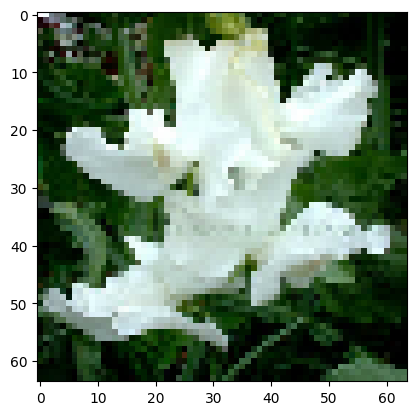

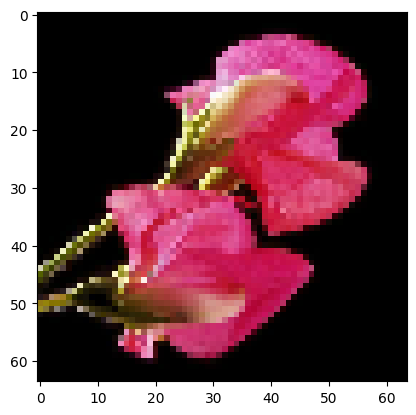

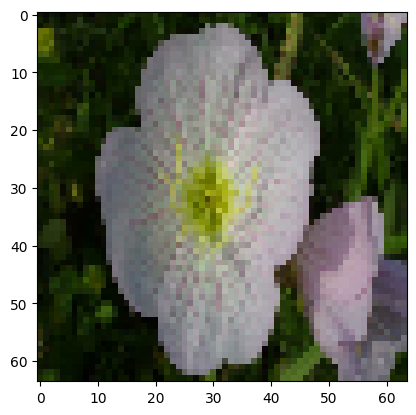

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


In [9]:
BATCH_SIZE = 64
dataset = dataset_generator(data_path + '/text2ImgData.pkl', BATCH_SIZE, training_data_generator)

for img, caption in dataset.take(1):
    plt.imshow(img[0])
    plt.show()
    plt.imshow(img[1])
    plt.show()
    plt.imshow(img[2])
    plt.show()
    print(tf.reduce_max(img[0]), tf.reduce_min(img[0]))

## Conditional GAN

### Text Encoder

In [10]:
class TextEncoder(tf.keras.Model):
    """
    Encode text (a caption) into hidden representation
    input: text, which is a list of ids
    output: embedding, or hidden representation of input text in dimension of RNN_HIDDEN_SIZE
    """
    def __init__(self, hparas):
        super(TextEncoder, self).__init__()
        self.hparas = hparas
        self.batch_size = self.hparas['BATCH_SIZE']
        
        # embedding with tensorflow API
        self.embedding = layers.Embedding(self.hparas['VOCAB_SIZE'], self.hparas['EMBED_DIM'])
        # RNN, here we use GRU cell, another common RNN cell similar to LSTM
        self.gru = layers.GRU(self.hparas['RNN_HIDDEN_SIZE'],
                              return_sequences=True,
                              return_state=True,
                              recurrent_initializer='glorot_uniform')
    
    def call(self, text, hidden):
        text = self.embedding(text)
        # output: (batch_size, sequence_length, rnn_hidden_size)
        output, state = self.gru(text, initial_state = hidden)
        # we only need to output the last hidden state of RNN
        return output[:, -1, :], state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.hparas['BATCH_SIZE'], self.hparas['RNN_HIDDEN_SIZE']))

In [11]:
# from transformers import TFBertModel, BertTokenizer

# # Need to modify the input as raw text?
# class TextEncoder(tf.keras.Model):
#     def __init__(self, hparas):
#         super(TextEncoder, self).__init__()
#         self.hparas = hparas
        
#         # Load pre-trained BERT model and tokenizer
#         self.embedding = tf.keras.layers.Embedding(
#             input_dim = self.hparas['VOCAB_SIZE'],
#             output_dim = 768
#         )
#         self.bert_model = TFBertModel.from_pretrained('bert-base-uncased')
#         self.bert_model.trainable = False
        
#         # Projection layer to match hidden size
#         self.projection = tf.keras.layers.Dense(
#             self.hparas.get('RNN_HIDDEN_SIZE', 768)
#         )
    
#     def call(self, text, hidden=None):
#         # Tokenize and encode text
#         attention_mask = tf.cast(text != word2Id_dict['<PAD>'], tf.int32)
#         embeddings = self.embedding(text)
#         outputs = self.bert_model(
#             input_ids=text,
#             attention_mask=attention_mask
#         )
#         pooled = outputs.pooler_output
#         final_embedding = self.projection(pooled)

#         return final_embedding, final_embedding

    
#     def initialize_hidden_state(self):
#         return tf.zeros((self.hparas['BATCH_SIZE'], self.hparas.get('RNN_HIDDEN_SIZE', 768)))

### Generator

In [12]:
class Generator(tf.keras.Model):
    """
    Generate fake image based on given text(hidden representation) and noise z
    input: text and noise
    output: fake image with size 64*64*3
    """
    def __init__(self, hparas):
        super(Generator, self).__init__()
        self.hparas = hparas
        # self.flatten = tf.keras.layers.Flatten()
        # self.d1 = tf.keras.layers.Dense(self.hparas['DENSE_DIM'])
        # self.d2 = tf.keras.layers.Dense(64*64*3)

        # Dense layer for text embedding
        # self.text_flatten = tf.keras.layers.Flatten()
        self.text_dense1 = tf.keras.layers.Dense(self.hparas['DENSE_DIM'])
        self.text_dense2 = tf.keras.layers.Dense(128 * 8 * 4 * 4)

        # Convolution layers for image generation
        self.deconv1 = tf.keras.layers.Conv2DTranspose(128 * 4, (4, 4), strides=(2, 2), padding='same', use_bias=False)
        self.deconv2 = tf.keras.layers.Conv2DTranspose(128 * 2, (4, 4), strides=(2, 2), padding='same', use_bias=False)
        self.deconv3 = tf.keras.layers.Conv2DTranspose(128 * 1, (4, 4), strides=(2, 2), padding='same', use_bias=False)
        self.final_conv = tf.keras.layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', use_bias=False)

        # Batch normalization
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.bn_text = tf.keras.layers.BatchNormalization()

        # Dropout
        self.dropout = tf.keras.layers.Dropout(0.5)

        
    def call(self, text, noise_z, training=True):
        # text = self.flatten(text)
        # text = self.d1(text)
        # text = tf.nn.leaky_relu(text)
        
        # # concatenate input text and random noise
        # text_concat = tf.concat([noise_z, text], axis=1)
        # text_concat = self.d2(text_concat)
        
        # logits = tf.reshape(text_concat, [-1, 64, 64, 3])
        # output = tf.nn.tanh(logits)

        # text = self.text_flatten(text)
        text = self.text_dense1(text)
        text = self.bn_text(text, training=training)
        text = tf.nn.relu(text)

        # concatenate input text and random noise
        text_concat = tf.concat([noise_z, text], axis=1)
        text_concat = self.text_dense2(text_concat)

        # Reshape and generate image
        x = tf.reshape(text_concat, [-1, 4, 4, 128 * 8])

        # Deconvolution layers
        x = self.deconv1(x)
        x = self.bn1(x, training=training)
        # x = self.dropout(x, training=True)
        x = tf.nn.relu(x)

        x = self.deconv2(x)
        x = self.bn2(x, training=training)
        # x = self.dropout(x, training=True)
        x = tf.nn.relu(x)

        x = self.deconv3(x)
        x = self.bn3(x, training=training)
        # x = self.dropout(x, training=True)
        x = tf.nn.relu(x)

        # Final layer with tanh activation
        logits = self.final_conv(x)
        output = tf.nn.tanh(logits)
        
        return output

### Discriminator

In [13]:
class Discriminator(tf.keras.Model):
    """
    Differentiate the real and fake image
    input: image and corresponding text
    output: labels, the real image should be 1, while the fake should be 0
    """
    def __init__(self, hparas):
        super(Discriminator, self).__init__()
        self.hparas = hparas
        # self.flatten = tf.keras.layers.Flatten()
        # self.d_text = tf.keras.layers.Dense(self.hparas['DENSE_DIM'])
        # self.d_img = tf.keras.layers.Dense(self.hparas['DENSE_DIM'])
        # self.d = tf.keras.layers.Dense(1)

        # Convolution layers
        self.conv1 = tf.keras.layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', use_bias=False)
        self.conv2 = tf.keras.layers.Conv2D(64 * 2, (4, 4), strides=(2, 2), padding='same', use_bias=False)
        self.conv3 = tf.keras.layers.Conv2D(64 * 4, (4, 4), strides=(2, 2), padding='same', use_bias=False)

        # Batch normalization
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.bn_text = tf.keras.layers.BatchNormalization()

        # Flatten and dense layers
        self.flatten = tf.keras.layers.Flatten()

        # Dropout layer
        self.dropout = tf.keras.layers.Dropout(0.5)

        # Conditional processing
        self.text_dense = tf.keras.layers.Dense(64 * 4)
        self.final_dense = tf.keras.layers.Dense(1)
    
    def call(self, img, text, training=True):
        # text = self.flatten(text)
        # text = self.d_text(text)
        # text = tf.nn.leaky_relu(text)
        
        # img = self.flatten(img)
        # img = self.d_img(img)
        # img = tf.nn.leaky_relu(img)
        
        # # concatenate image with paired text
        # img_text = tf.concat([text, img], axis=1)
        
        # logits = self.d(img_text)
        # output = tf.nn.sigmoid(logits)
        
        # Process image
        x = self.conv1(img)
        x = tf.nn.leaky_relu(x, alpha=0.2)

        x = self.conv2(x)
        x = self.bn1(x, training=training)
        x = tf.nn.leaky_relu(x, alpha=0.2)

        x = self.conv3(x)
        x = self.bn2(x, training=training)
        x = tf.nn.leaky_relu(x, alpha=0.2)

        x = self.flatten(x)
        # x = self.dropout(x, training=True)

        # Process text condition
        text_processed = self.text_dense(text)
        text_processed = self.bn_text(text_processed, training=training)

        # Concatenate image features and text
        combined = tf.concat([x, text_processed], axis=1)
        # combined = self.dropout(combined, training=True)

        # Final classification
        logits = self.final_dense(combined)
        output = tf.nn.sigmoid(logits)
        # output = logits

        return logits

In [14]:
@tf.function
def image_aug(img):
    img = tf.image.random_flip_left_right(img)
    height, width = img.shape[1], img.shape[2]

    # random tranlation
    # dx = tf.random.uniform([], -5, 5, dtype=tf.int32)
    # dy = tf.random.uniform([], -5, 5, dtype=tf.int32)
    # img = tf.image.pad_to_bounding_box(
    #     img, 
    #     offset_height=tf.maximum(0, dy), 
    #     offset_width=tf.maximum(0, dx), 
    #     target_height=height + tf.abs(dy), 
    #     target_width=width + tf.abs(dx)
    # )
    # img = tf.image.crop_to_bounding_box(
    #     img, 
    #     offset_height=tf.maximum(0, -dy), 
    #     offset_width=tf.maximum(0, -dx), 
    #     target_height=height, 
    #     target_width=width
    # )

    # random crop
    # crop_height = tf.random.uniform([], int(height * 0.8), height, dtype=tf.int32)
    # crop_width = tf.random.uniform([], int(width * 0.8), width, dtype=tf.int32)
    # img = tf.image.random_crop(img, size=[img.shape[0], crop_height, crop_width, img.shape[3]])
    # img = tf.image.resize(img, [height, width])

    # random zoom
    # zoom_factor = tf.random.uniform([], 0.8, 1)
    # new_height, new_width = tf.cast(height * zoom_factor, tf.int32), tf.cast(width * zoom_factor, tf.int32)
    # img = tf.image.resize(img, [new_height, new_width])
    # img = tf.image.resize(img, [height, width])

    # saturation = tf.random.uniform([], 0.6, 1.4)
    # img = tf.image.adjust_saturation(img, saturation)

    # rotate
    # angle = tf.random.uniform([], -30, 30)
    # img = tfa.image.rotate(img, angle)

    # add noise
    # noise = tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=0.05, dtype=tf.float32)
    # img = img + noise

    # img = img * 2.0 - 1
    # img = tf.clip_by_value(img, -1, 1)
    return img

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
(64, 64, 64, 3)


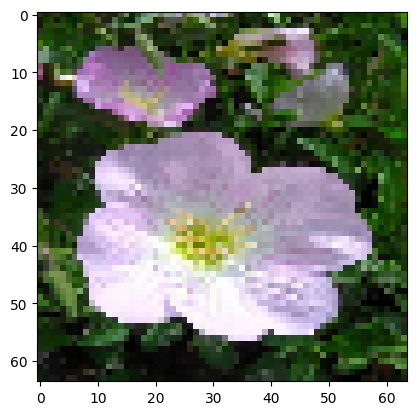

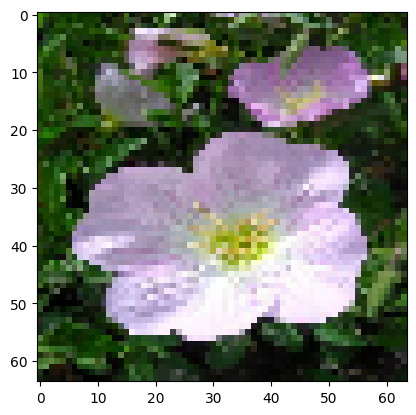

In [15]:
for img, caption in dataset.take(1):
    new_img = image_aug(img)
    print(tf.reduce_max(img), tf.reduce_min(img))
    print(tf.reduce_max(new_img), tf.reduce_min(new_img))
    print(new_img.shape)
    plt.imshow(img[0].numpy())
    plt.show()
    plt.imshow(new_img[0].numpy())
    plt.show()

In [16]:
class WGAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim, discriminator_extra_steps=3, gp_weight=10.0):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images, captions):
        """Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, captions, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, data):
        real_images, captions = data
        # real_images = image_aug(real_images)
        real_images = real_images * 2.0 - 1
        real_images = tf.clip_by_value(real_images, -1, 1)
        
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator(captions, random_latent_vectors, training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_images, captions, training=True)
                # Get the logits for the real images
                real_logits = self.discriminator(real_images, captions, training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images, captions)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images  = self.generator(captions, random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            gen_img_logits  = self.discriminator(generated_images, captions, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}

In [17]:
class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, num_img=6, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(test_use_caption, random_latent_vectors)
        generated_images = (generated_images * 127.5) + 127.5

        for i in range(self.num_img):
            img = generated_images[i].numpy()
            img = tf.keras.utils.array_to_img(img)
            img.save("./samples/wgan-gp/generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))


In [18]:
hparas = {
    'MAX_SEQ_LENGTH': 20,                     # maximum sequence length
    'EMBED_DIM': 256,                         # word embedding dimension
    'VOCAB_SIZE': len(word2Id_dict),          # size of dictionary of captions
    'RNN_HIDDEN_SIZE': 512,                   # number of RNN neurons
    'Z_DIM': 128,                             # random noise z dimension
    'DENSE_DIM': 512,                         # number of neurons for text embedding
    'IMAGE_SIZE': [64, 64, 3],                # render image size
    'BATCH_SIZE': 64,
    'LR': 1e-4,
    'LR_DECAY': 0.5,
    'BETA_1': 0.5,
    'N_EPOCH': 1500,                            # number of epoch for demo
    'N_SAMPLE': num_training_sample,          # size of training data
    'CHECKPOINTS_DIR': './checkpoints/wgan',  # checkpoint path
    'PRINT_FREQ': 100                           # printing frequency of loss
}

In [19]:
text_encoder = TextEncoder(hparas)
generator = Generator(hparas)
discriminator = Discriminator(hparas)


In [20]:
# Instantiate the optimizer for both networks
# (learning_rate=0.0002, beta_1=0.5 are recommended)
generator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)


# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)


# Set the number of epochs for training.
epochs = hparas['N_EPOCH']

# Instantiate the customer `GANMonitor` Keras callback.
cbk = GANMonitor(num_img=3, latent_dim=hparas['Z_DIM'])

# Get the wgan model
wgan = WGAN(
    discriminator=discriminator,
    generator=generator,
    latent_dim=hparas['Z_DIM'],
    discriminator_extra_steps=5,
)

# Compile the wgan model
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)


In [21]:
checkpoint_path = "checkpoints/wgan-gp/tf_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    # max_to_keep=1
)
wgan.load_weights(checkpoint_path)
# Start training
# wgan.fit(dataset, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk, checkpoint_callback])

In [22]:
@tf.function
def test_step(caption, noise):
    fake_image = generator(caption, noise)
    return fake_image

## Evaluation
If you change anything during preprocessing of training dataset, you must make sure same operations have be done in testing dataset.

In [31]:
def testing_data_generator(caption, index):
    caption = tf.convert_to_tensor(caption, dtype=tf.float32)
    # caption = tf.cast(caption, tf.float32)
    return caption, index

def testing_dataset_generator(batch_size, data_generator):
    data = pd.read_pickle('./clip_test_text_features.pkl')
    # captions = data.values
    # print(list(data.iloc[0]))
    caption = []
    index = []
    for i in range(len(data)):
        # caption.append(captions[i])
        c = data.iloc[i]['Captions']
        t = data.iloc[i]['ID']

        caption.append(c)
        index.append(t)
    # caption = np.asarray(caption)
    # caption = caption.astype(np.int)
    # index = data['ID'].values
    # index = np.asarray(index)
    
    dataset = tf.data.Dataset.from_tensor_slices((caption, index))
    dataset = dataset.map(data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.repeat().batch(batch_size)
    
    return dataset

In [37]:
hparas['BATCH_SIZE'] = 39
testing_dataset = testing_dataset_generator(hparas['BATCH_SIZE'], testing_data_generator)
for caption, index in testing_dataset.take(2):
    print(caption)
    print(index)

tf.Tensor(
[[-0.19348145 -0.14331055  0.38208008 ...  0.35058594  0.25610352
  -0.21472168]
 [-0.31982422  0.17797852  0.40551758 ...  0.20910645  0.2722168
   0.15356445]
 [-0.32055664  0.14099121  0.2253418  ...  0.09710693  0.19714355
  -0.26245117]
 ...
 [-0.14501953  0.09405518  0.04077148 ...  0.1817627   0.07006836
  -0.10003662]
 [-0.07312012  0.13769531  0.38793945 ...  0.2680664  -0.0139389
  -0.18151855]
 [-0.10913086  0.13208008  0.03025818 ...  0.10308838  0.29125977
  -0.08166504]], shape=(39, 512), dtype=float32)
tf.Tensor(
[6735 6740 6746 6759 6762 6765 5107 5108 5133 6623 6647 5655 5666 5682
 5147 5148 5175 5177 5181 5184 5187 5190 5198 7175 7184 7190 7192 7203
 7208 7219 7222 7225 7227 8101 3284 3296 3322 3323 3327], shape=(39,), dtype=int32)
tf.Tensor(
[[-0.1315918   0.3713379   0.29296875 ...  0.28979492 -0.04519653
  -0.20629883]
 [-0.09399414  0.0094223  -0.04754639 ...  0.14575195  0.2565918
  -0.09466553]
 [-0.12139893  0.1940918   0.2788086  ... -0.22583008  0.

In [38]:
data = pd.read_pickle('./dataset/testData.pkl')
captions = data['Captions'].values

NUM_TEST = len(captions)
print(NUM_TEST)
EPOCH_TEST = int(NUM_TEST / hparas['BATCH_SIZE'])

819


## Inference

In [39]:
if not os.path.exists('./inference/demo'):
    os.makedirs('./inference/demo')

In [40]:
def inference(dataset):
    sample_size = hparas['BATCH_SIZE']
    sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, hparas['Z_DIM'])).astype(np.float32)
    
    step = 0
    start = time.time()
    for captions, idx in dataset:
        if step > EPOCH_TEST:
            break
        
        fake_image = test_step(captions, sample_seed)
        step += 1
        for i in range(hparas['BATCH_SIZE']):
            plt.imsave('./inference/demo/inference_{:04d}.jpg'.format(idx[i]), fake_image[i].numpy()*0.5 + 0.5)
            
    print('Time for inference is {:.4f} sec'.format(time.time()-start))

In [41]:
inference(testing_dataset)

Time for inference is 2.0062 sec


## Inception Score & Cosine Similarity
- Similarity of images and the given contents. How similar are the generated images and the given texts?
- KL divergence of generated images. Are the generated images very diverse?

### Run evaluation script

1. Open terminal and move to the folder containing inception_score.py. Otherwise you have to modify the path used in the file.
2. Run python ./inception_score.py [argv1] [argv2] [argv3]
    - argv1: directory of generated image (inference).
    - argv2: directory of output file and its name.
    - argv3: batch size. Please set batch size to 1, 2, 3, 7, 9, 21, 39 to avoid remainder.

For exmaple, run following comment 
`python inception_score.py ../inference/demo ../score_demo.csv 39`

It is better for you to know that evaluation needs to run on GPUs, please make sure the GPU resource is available.